In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [14]:
np.random.seed(112)
df = pd.read_csv("sarcasm.csv")
df['comment'] = df['comment'].fillna("")
df['length'] = df['comment'].apply(lambda x: len(x.split()))
print(df['length'])

0         3
1        14
2        19
3        12
4         7
         ..
99995     2
99996    17
99997     3
99998    11
99999     5
Name: length, Length: 100000, dtype: int64


In [15]:
tok = spacy.load('en_core_web_sm')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

counts = Counter()
for index, row in df.iterrows():
    counts.update(tokenize(row['comment']))
    
print("num_words before:", len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 46978
num_words after: 22726


In [17]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)
    
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

df['encoded'] = df['comment'].apply(lambda x: np.array(encode_sentence(x,vocab2index ), dtype=object))
df.head()
Counter(df['label'])

Counter({0: 57690, 1: 42310})

In [18]:
X = list(df['encoded'])
y = list(df['label'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [19]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [20]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs +1 ):
        model.train()
        sum_loss = 0.0
        train_acc = 0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            loss = F.cross_entropy(y_pred, y)
            _, pred = torch.max(y_pred.data, 1)
            train_acc += (pred == y).sum().item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl, i)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, 100 * val_loss, val_acc, val_rmse))
        tra_accur = 100 * train_acc / len(train_ds)
        if i % 1 == 0:
            print(f'Epoch: {i+1}, training accuracy: {tra_accur}')
def conf_matrix_table(cf_matrix):
    group_names = ['TN','FP','FN','TP']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, cf_matrix.flatten(), group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.show()
def validation_metrics (model, valid_dl, i):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    
    y_pred = []
    y_true= []
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        y_pred.extend(pred.data.numpy())
        y_true.extend(y.data.numpy())
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    cf_matrix = confusion_matrix(y_true, y_pred, labels=[0,1])
    conf_matrix_table(cf_matrix=cf_matrix)
    if i == 30:
        print("conf matrix: \n",cf_matrix )

    return sum_loss/total, correct/total, sum_rmse/total  

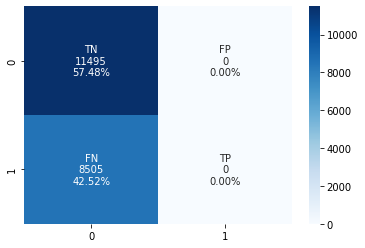

Epoch: 1, training accuracy: 54.67125


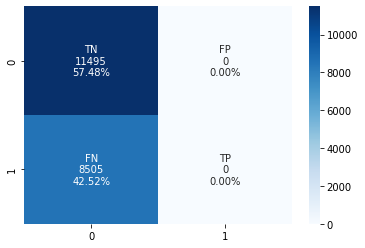

train loss 0.685, val loss 68.194, val accuracy 0.575, and val rmse 0.652
Epoch: 2, training accuracy: 56.705


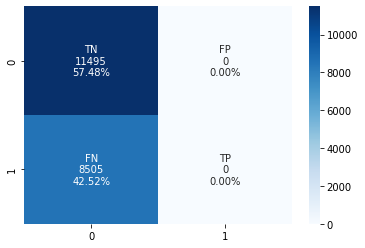

Epoch: 3, training accuracy: 57.74375


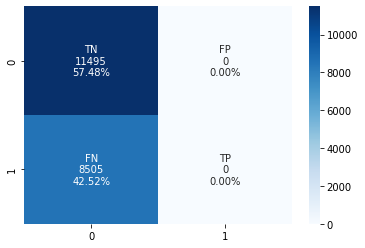

Epoch: 4, training accuracy: 57.74375


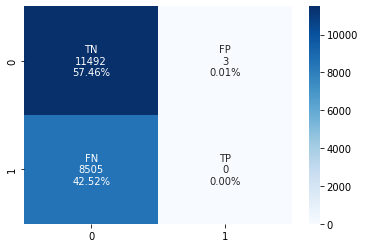

Epoch: 5, training accuracy: 57.74625


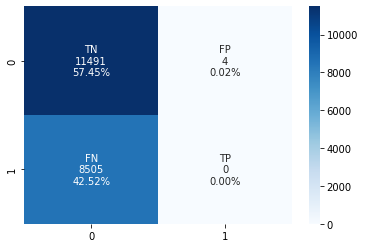

Epoch: 6, training accuracy: 57.75


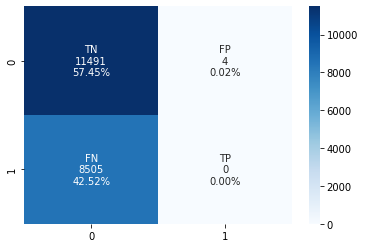

train loss 0.682, val loss 68.277, val accuracy 0.575, and val rmse 0.652
Epoch: 7, training accuracy: 57.75375


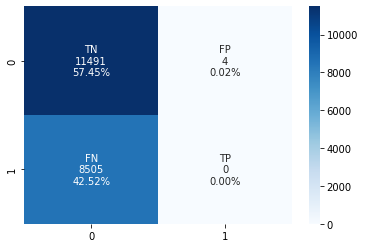

Epoch: 8, training accuracy: 57.7575


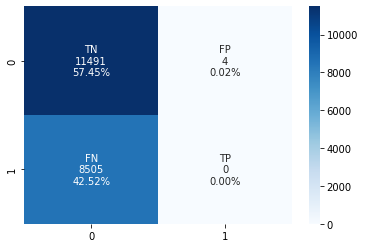

Epoch: 9, training accuracy: 57.76


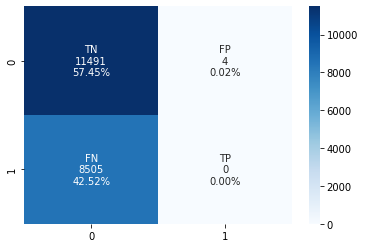

Epoch: 10, training accuracy: 57.76125


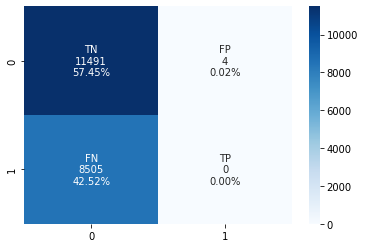

Epoch: 11, training accuracy: 57.76125


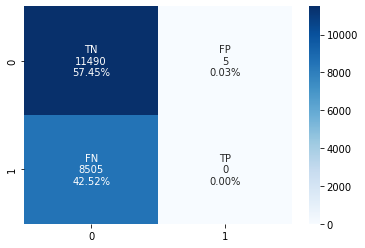

train loss 0.681, val loss 68.217, val accuracy 0.575, and val rmse 0.652
Epoch: 12, training accuracy: 57.76


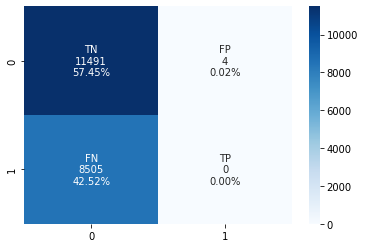

Epoch: 13, training accuracy: 57.76125


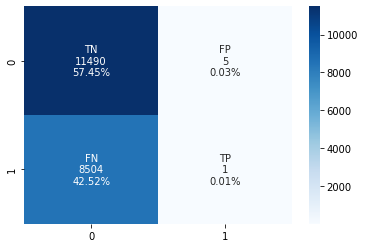

Epoch: 14, training accuracy: 57.76125


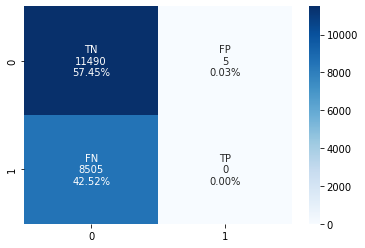

Epoch: 15, training accuracy: 57.7625


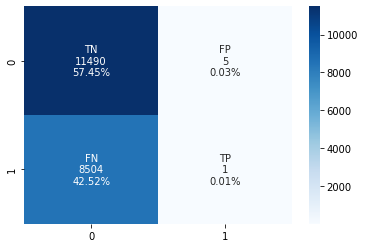

Epoch: 16, training accuracy: 57.76125


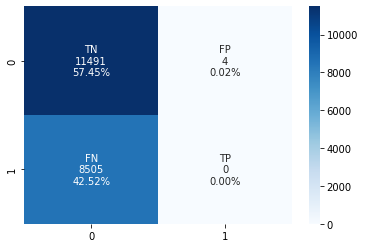

train loss 0.681, val loss 68.225, val accuracy 0.575, and val rmse 0.652
Epoch: 17, training accuracy: 57.76125


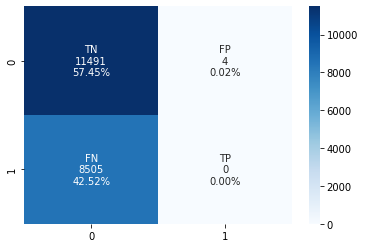

Epoch: 18, training accuracy: 57.7625


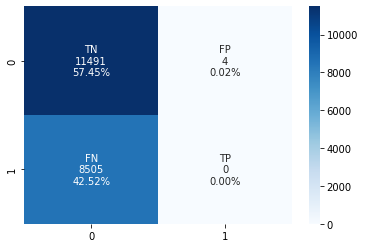

Epoch: 19, training accuracy: 57.76


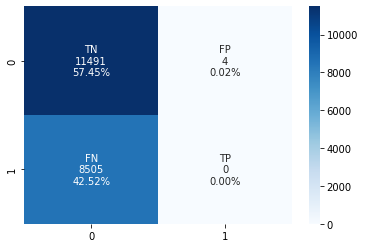

Epoch: 20, training accuracy: 57.76125


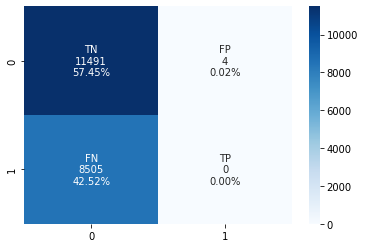

Epoch: 21, training accuracy: 57.75875


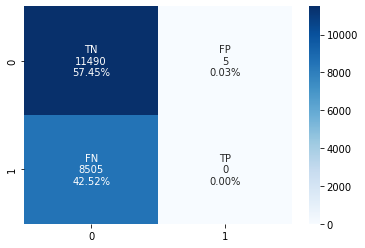

train loss 0.671, val loss 67.140, val accuracy 0.575, and val rmse 0.652
Epoch: 22, training accuracy: 57.7625


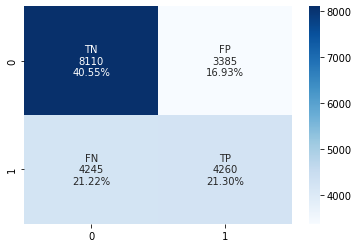

Epoch: 23, training accuracy: 59.8175


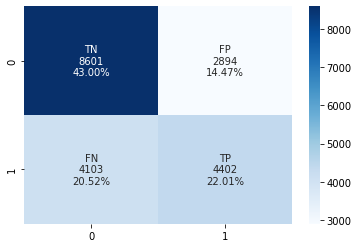

Epoch: 24, training accuracy: 66.46


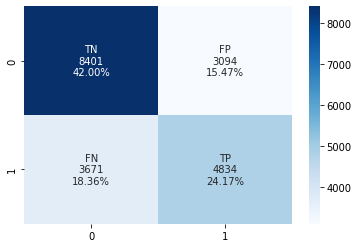

Epoch: 25, training accuracy: 70.3075


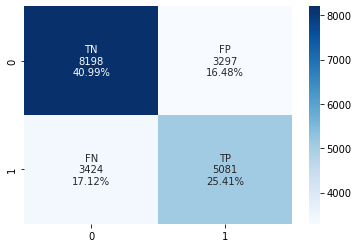

Epoch: 26, training accuracy: 73.16


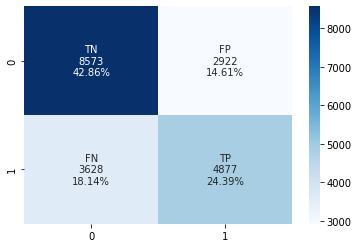

train loss 0.519, val loss 63.403, val accuracy 0.673, and val rmse 0.572
Epoch: 27, training accuracy: 75.0175


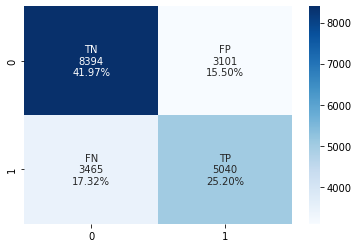

Epoch: 28, training accuracy: 76.6975


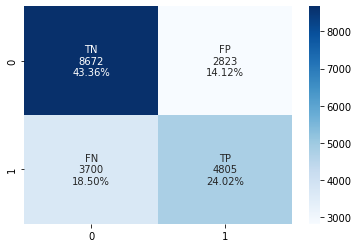

Epoch: 29, training accuracy: 77.74375


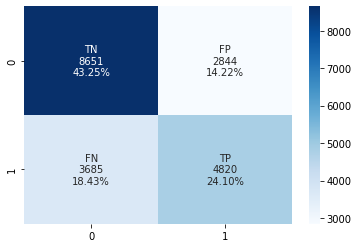

Epoch: 30, training accuracy: 79.0275


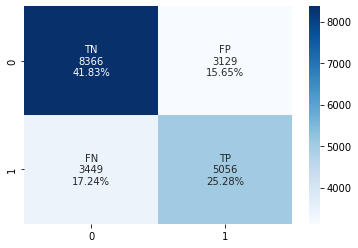

conf matrix: 
 [[8366 3129]
 [3449 5056]]
Epoch: 31, training accuracy: 79.90625


In [21]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 25)
        self.linear2 = nn.Linear(25, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear2(self.linear(ht[-1]))
    
model_fixed =  LSTM_fixed_len(vocab_size, 50, 50)

train_model(model_fixed, epochs=30, lr=0.01)